In [1]:
IBM_QUANTUM_TOKEN = 'e77a3b005b03f9c66b778b6edc236f7356d7b38a4e2dfa1811877105a08b8d3db3e79f1fa56fa222d60ec51627c942a2684a213073ccd095c0cd6403bf3ad6b3'

In [2]:
import os
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2, Session
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy, linregress
import seaborn as sns

# Initialize IBM Quantum Service
service = QiskitRuntimeService(
    channel="ibm_quantum",
    instance="ibm-q/open/main",
    token=IBM_QUANTUM_TOKEN
)

In [3]:
backend = service.backend("ibm_brisbane")  # Use IBM Brisbane

# Get latest calibration data for noise model
noise_model = NoiseModel.from_backend(backend)
simulator = AerSimulator(noise_model=noise_model, basis_gates=noise_model.basis_gates)

def create_cat_state_circuit(n):
    qc = QuantumCircuit(n, n)
    qc.h(0)
    for i in range(1, n):
        qc.cx(0, i)
    qc.measure(range(n), range(n))
    return qc

# Define parameters
min_qubits, max_qubits = 2, 14  # Adjusted max qubits to 14 for free-tier limit
shot_counts = [2**i for i in range(12, 19)]  # 8192 to 131072 shots

# Transpile circuits to get real gate data
transpiled_circuits = {n: transpile(create_cat_state_circuit(n), backend) for n in range(min_qubits, max_qubits + 1)}

# Estimate time limits for free-tier usage using transpiled circuit data
target = backend.target

def get_instruction_duration(gate, qubits, qc):
    """Retrieve the duration of a specific gate on given qubits."""
    try:
        # Convert qubits to indices by searching for their position in the QuantumCircuit qubits list
        qubit_indices = tuple(qc.qubits.index(q) for q in qubits)

        # Use InstructionDurations API to get the duration for the gate on the specified qubits
        return target[gate].duration if qubits in target[gate] else 0
    except KeyError:
        return 0

def estimate_circuit_time(qc, shots):
    """Estimate the total execution time of a circuit for a given number of shots."""
    total_time = 0
    for instruction in qc.data:
        gate = instruction.operation.name
        qubits = tuple(q for q in instruction.qubits)  # Get qubits directly
        total_time += get_instruction_duration(gate, qubits, qc)  # Ensure qc is passed here
    # Add measurement duration for each qubit
    for qubit in range(qc.num_qubits):
        total_time += get_instruction_duration("measure", (qc.qubits[qubit],), qc)  # Ensure qc is passed for measurement
    return total_time * shots

# Optimize counts vs qubits under the free-tier runtime limit
max_runtime_seconds = 300  # 5-minute limit
optimal_shot_counts = []
total_runtime = 0
for shots in shot_counts:
    print("Running for ", shots, " shots")
    for n in range(min_qubits, max_qubits + 1):
        estimated_runtime = estimate_circuit_time(transpiled_circuits[n], shots)
        if total_runtime + estimated_runtime < max_runtime_seconds:
            optimal_shot_counts.append((n, shots))
            total_runtime += estimated_runtime
        else:
            break

# Store results
entropy_results = {shots: [] for _, shots in optimal_shot_counts}
qubit_range = sorted(set(n for n, _ in optimal_shot_counts))

# Simulate on noisy Aer simulator
simulated_circuits = []
for n, shots in optimal_shot_counts:
    simulated_circuits.append((transpiled_circuits[n], shots))

jobs = [simulator.run(tc, shots=s) for tc, s in simulated_circuits]
results = [job.result() for job in jobs]

for result, (n, shots) in zip(results, optimal_shot_counts):
    counts = result.get_counts()
    probabilities = np.array(list(counts.values())) / shots
    ent = entropy(probabilities, base=2)
    entropy_results[shots].append(ent)

Running for  4096  shots
Running for  8192  shots
Running for  16384  shots
Running for  32768  shots
Running for  65536  shots
Running for  131072  shots
Running for  262144  shots


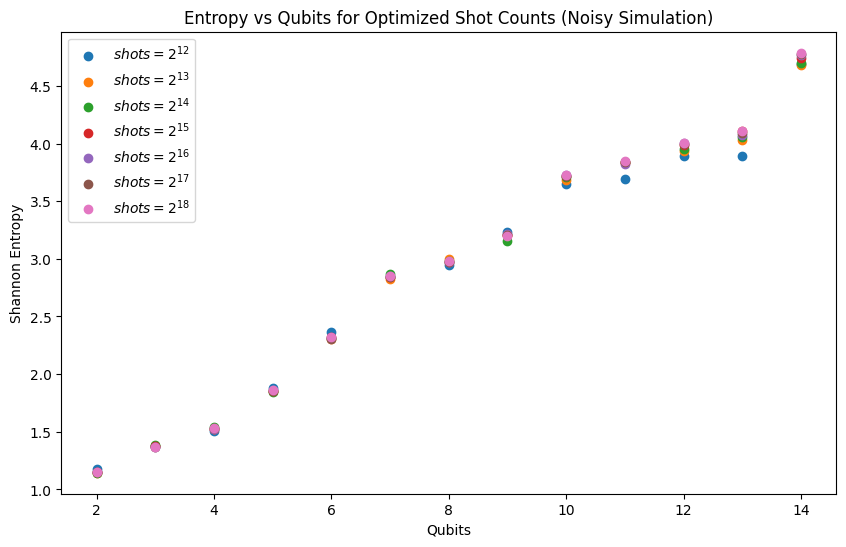

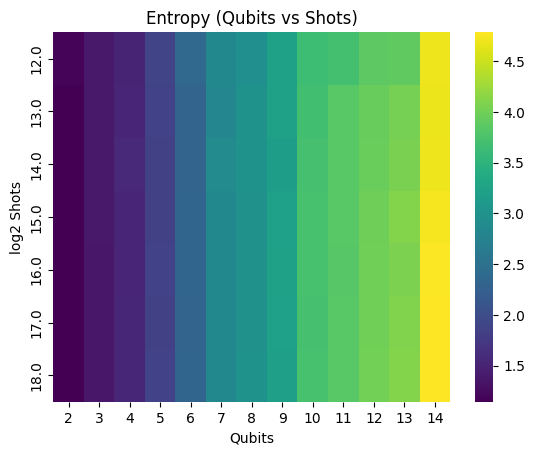

In [4]:
# Plot entropy vs qubits for each shot count with linear fits
plt.figure(figsize=(10, 6))
for shots, entropies in entropy_results.items():

    lbl = ("$shots = 2^{{{}}}$").format(int(np.log2(shots)))
    plt.scatter(qubit_range, entropies, label= lbl)

plt.xlabel("Qubits")
plt.ylabel("Shannon Entropy")
plt.title("Entropy vs Qubits for Optimized Shot Counts (Noisy Simulation)")
plt.legend()
plt.show()

# Heatmap of qubits vs shots with Shannon entropy
entropy_matrix = np.array([[entropy_results[s][i] if i < len(entropy_results[s]) else np.nan for i in range(len(qubit_range))] for s in shot_counts])
sns.heatmap(entropy_matrix, xticklabels=qubit_range, yticklabels=np.log2(shot_counts), cmap="viridis")
plt.xlabel("Qubits")
plt.ylabel("log2 Shots")
plt.title("Entropy (Qubits vs Shots)")
plt.show()
